In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import random
import xlsxwriter
import math
import statistics
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import matplotlib.pyplot as pl

In [2]:
# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['target'] = y

In [11]:
#Prepare model
rf_g = {
    "name" : "Random Forest",
    "model" : RandomForestClassifier()
}

bg_c = {
    "name" : "Bagging",
    "model" : BaggingClassifier()
}

In [3]:
#Parameter:
# (DataFrame) dataframe - contains dataset
# (int) number_of_folds - number of division on the dataset

#Return: List of divided DataFrame

def slide_df_to_n_folds (data_frame, number_of_folds) :
    #--General function variables
    wrapper_array = []
    list_of_divided_dataframe = []

    #--Shuffle and divide the index of data_frame
    index_of_df = list(range(data_frame.shape[0]))
    random.shuffle(index_of_df)
    #Calculate the number of fold will be divided into
    number_of_element_per_fold = math.ceil(len(index_of_df)/number_of_folds)
    #Divide the list of array into the corresponding fold
    for k in range (0, len(index_of_df), number_of_element_per_fold):
        wrapper_array.append(index_of_df[k:k+number_of_element_per_fold])

    #--Divide the dataframe based on the index was created
    for m in range(len(wrapper_array)):
        new_dataframe = data_frame.iloc[wrapper_array[m]]
        list_of_divided_dataframe.append(new_dataframe)

    return list_of_divided_dataframe


In [4]:
def prepare_train_test_tuples (list_of_divided_dataframe):
    train_test_tuples = []
    for inx, fold in enumerate(list_of_divided_dataframe):
        train_dfs = list_of_divided_dataframe[:inx] + list_of_divided_dataframe[inx+1:]
        train_df = pd.concat(train_dfs,axis=0)
        test_df = list_of_divided_dataframe[inx]

        train_test_tuples.append((train_df, test_df))

    return train_test_tuples

In [5]:
#
def cross_validate(models, dataset ,fold_number = 5):

    #--Prepare data
    folds = slide_df_to_n_folds (dataset, fold_number)
    train_test_tuples = prepare_train_test_tuples(folds)
    truth_val_tests = []

    for train_test_tuple in train_test_tuples:
        truth_val_tests.append(train_test_tuple[1]["target"])

    model_predictions_tuples = []
    for model in models:
        predictions = []

        for train_test_tuple in train_test_tuples:
            train_data = train_test_tuple[0]
            test_data = train_test_tuple[1]

            #--Train model on training fold
            model["model"].fit(train_data.drop(columns='target'), train_data.target)
            #--Make prediction
            prediction_result = model["model"].predict(test_data.drop(columns='target'))

            predictions.append(prediction_result)

        model_predictions_tuples.append((model,predictions))

    return truth_val_tests, model_predictions_tuples

In [6]:
def prepare_metrics_errdevs_tuples (truth_val_tests, model_predictions_tuples):

    model_metrics_errdevs_tuples = []

    for inx, model_predictions_tuple in enumerate(model_predictions_tuples):

        acc_scores = []
        f1_scores = []

        for iny, truth_val_test in enumerate(truth_val_tests):
            acc_sc =  accuracy_score(truth_val_test, model_predictions_tuple[1][iny])
            f1_sc = f1_score(truth_val_test, model_predictions_tuple[1][iny],average='macro')

            acc_scores.append(acc_sc)
            f1_scores.append(f1_sc)

        acc_mean = statistics.mean(acc_scores)
        f1_mean = statistics.mean(f1_scores)

        acc_dev = statistics.stdev(acc_scores)
        f1_dev = statistics.stdev(f1_scores)

        model_metrics_errdevs_tuples.append((model_predictions_tuple[0],[acc_scores,f1_scores], [acc_mean,f1_mean],[acc_dev,f1_dev]))

    return model_metrics_errdevs_tuples

In [7]:
def save_crvInfo_to_xlsx (truth_val_tests,  model_predictions_tuples):
    model_metrics_errdevs_tuples = prepare_metrics_errdevs_tuples(truth_val_tests, model_predictions_tuples)

    workbook = xlsxwriter.Workbook("../Result.xlsx")

    for inx, model_predictions_tuple in enumerate(model_metrics_errdevs_tuples):

        worksheet_fold = workbook.add_worksheet(model_predictions_tuple[0]["name"])

        row = 1

        worksheet_fold.write(0, 0, f"Fold number")
        worksheet_fold.write(0, 1, f"Accuracy score")

        for iny, mse in enumerate (model_predictions_tuple[1][0]):
            worksheet_fold.write(row, 0, f"{iny}")
            worksheet_fold.write(row, 1, f"{mse}")
            row += 1

        worksheet_fold.write(row, 0, f"Average error: {model_predictions_tuple[2][0]}")
        row += 1
        worksheet_fold.write(row, 0, f"Standard Derivation: {model_predictions_tuple[3][0]}")
        row += 1

        row += 3

        worksheet_fold.write(row, 0, f"Fold number")
        worksheet_fold.write(row, 1, f"F1 Score")

        row += 1

        for iny, mse in enumerate (model_predictions_tuple[1][1]):
            worksheet_fold.write(row, 0, f"{iny}")
            worksheet_fold.write(row, 1, f"{mse}")
            row += 1

        worksheet_fold.write(row, 0, f"Average error: {model_predictions_tuple[2][1]}")
        row += 1
        worksheet_fold.write(row, 0, f"Standard Derivation: {model_predictions_tuple[3][1]}")
        row += 1

        row += 3

    workbook.close()

    return

In [8]:
def plot_cv_results(truth_val_tests,model_predictions_tuples) :
    #Configure graph properties
    pl.rcParams['figure.figsize'] = [20, 15]
    #pl.rcParams["figure.autolayout"] = True

    #Define color line for different model
    model_color_dic = {
        "Random Forest" : "red",
        "Bagging" : "blue",
    }

    fig, ax = pl.subplots(len(truth_val_tests))

    for inx, truth_val_test in enumerate(truth_val_tests):
        # ax[inx].rcParams['figure.figsize'] = [30, 20]
        ax[inx].plot(truth_val_test.tolist(), linestyle="dotted", color="green",label= "Truth value")
        ax[inx].set_title(f"Fold number {inx}")
        ax[inx].legend(loc="upper right")

        for model_prediction_tuple in model_predictions_tuples:
            model_name = model_prediction_tuple[0]["name"]
            ax[inx].plot(model_prediction_tuple[1][inx], linestyle="dotted", color=f"{model_color_dic[model_name]}", label=model_name)
            ax[inx].legend(loc="upper right")

    fig.tight_layout()

In [18]:
#Input:

#Ouput:
# + Two box plot figure, first one is accuracy and second one is f1_score
# +
def box_plot_models_metrics (estimator_nums) :

    accuracies_data = []
    f1_scores_data = []

    for estimator_num in estimator_nums:
        bg_c = {
            "name" : "Bagging",
            "model" : BaggingClassifier(n_estimators=estimator_num)
        }

        truth_val_tests, model_predictions_tuples = cross_validate([bg_c],iris_df,5)
        model_metrics_errdevs_tuples = prepare_metrics_errdevs_tuples(truth_val_tests, model_predictions_tuples)

        accuracies = model_metrics_errdevs_tuples[0][1][0]
        f1_scores = model_metrics_errdevs_tuples[0][1][1]

        accuracies_data.append(accuracies)
        f1_scores_data.append(f1_scores)

    fig = pl.figure(figsize =(10, 7))
    fig.suptitle('Accuracy Score', fontsize=16)
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(accuracies_data)
    ax.set_xticklabels(estimator_nums)

    fig2 = pl.figure(figsize =(10, 7))
    fig2.suptitle('F1 Score', fontsize=16)
    ax2 = fig2.add_axes([0, 0, 1, 1])
    bp = ax2.boxplot(f1_scores_data)
    ax2.set_xticklabels(estimator_nums)

    return model_predictions_tuples


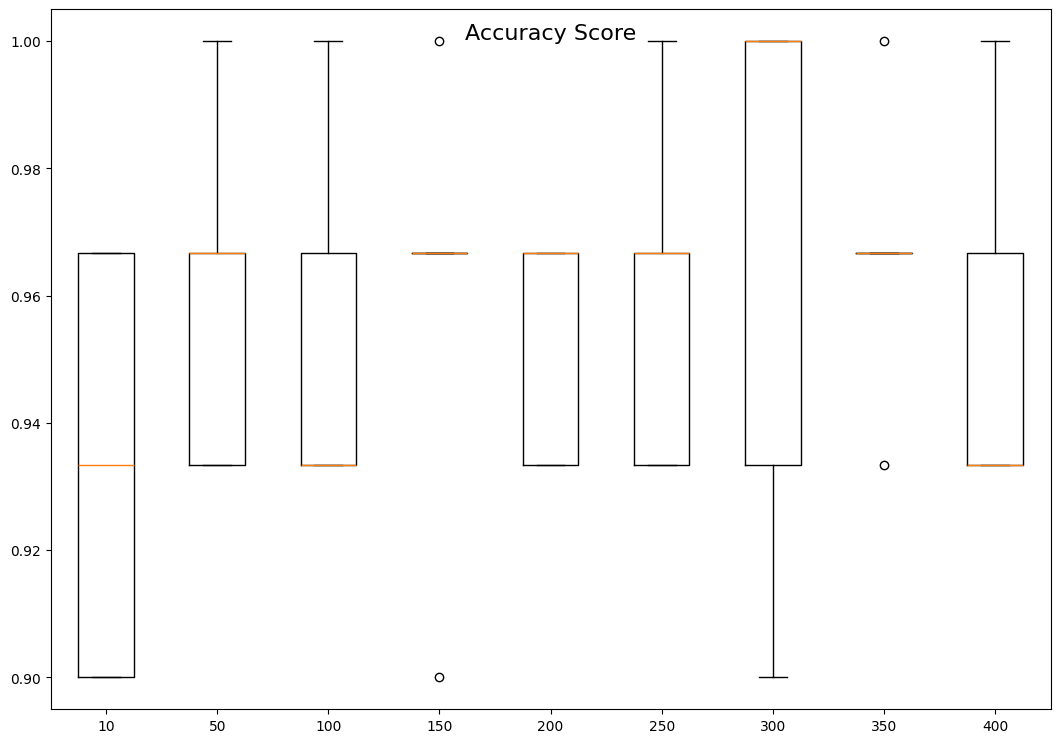

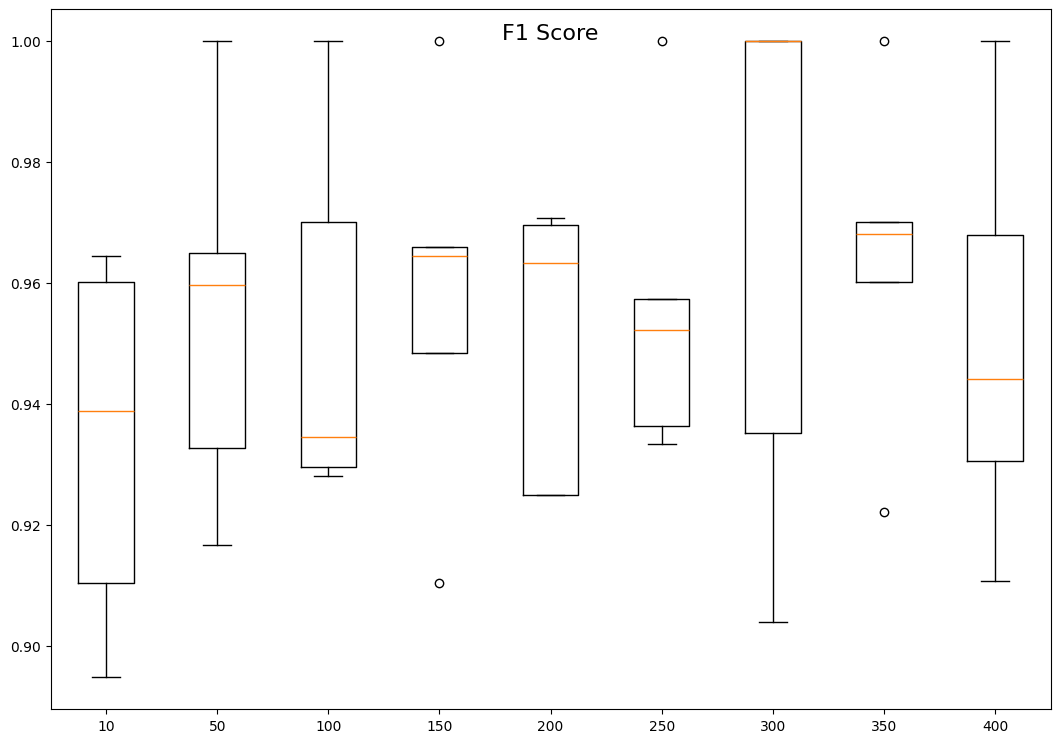

In [20]:
#Execution cell
models = [bg_c, rf_g]
#a = cross_validate(models,iris_df,5)
truth_val_tests, model_predictions_tuples = cross_validate(models,iris_df,5)
prepare_metrics_errdevs_tuples(truth_val_tests, model_predictions_tuples)
#plot_cv_results(truth_val_tests, model_predictions_tuples)
#save_crvInfo_to_xlsx(truth_val_tests, model_predictions_tuples)
estimator_nums = [10,50,100,150,200,250,300,350,400]
a = box_plot_models_metrics(estimator_nums)
